In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window, visualize_score_map
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor
from matcher import CnnMatcher, Window
from image import load_image
from feature_extractor import CNN, ReCNN, ResizeImageFeatureExtractor, FeatureExtractor, EdgeImageFeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer, Scorer
from shape.basic import Size
from utils.timer import timer

def visualize_result(img: np.ndarray, score_map: np.ndarray, threshold: float, rois: Candidates, best_window: Window, scores: torch.Tensor):
    fig, axes = plt.subplots(1, 4, figsize=(20, 3))
    axes[0].imshow(img)
    axes[1].imshow(score_map)
    axes[2].imshow(score_map > threshold)

    windows = rois.rois.cpu().numpy()
    best_pos_indices = (windows[:, 1] == best_window.cx) & (windows[:, 2] == best_window.cy)
    best_pos_windows = windows[best_pos_indices]
    best_pos_scores = scores.reshape(-1)[best_pos_indices].cpu().numpy()
    angles = best_pos_windows[:, 5]
    axes[3].plot(angles, best_pos_scores)
    axes[3].set_xlabel('angle')
    axes[3].set_ylabel('score')
    axes[3].set_ylim(0.0, 1.0)
    plt.show()

Text(0.5, 1.0, 'target')

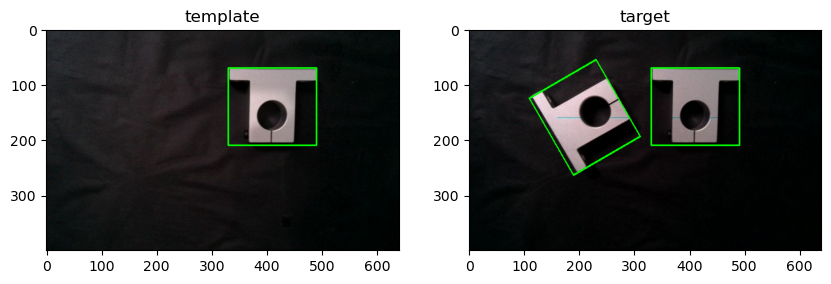

In [2]:
target_img = load_image('../data/image_1.png')
template_img = load_image('../data/template_1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

template_window = Window(410., 140., 160., 140., 0)
draw_img = draw_window(template_img, template_window)
axes[0].imshow(draw_img)
axes[0].set_title('template')

target_windows = [
    Window(210, 160, 160, 140, -120),
    Window(410., 140., 160., 140., 0)
    ]
draw_img = target_img.copy()
for target_window in target_windows:
    draw_img = draw_window(draw_img, target_window)
axes[1].imshow(draw_img)
axes[1].set_title('target')

In [3]:
target_image_size = Size(*target_img.shape[:2])
template_size = template_window.get_size()
scales = [2, 4, 8, 16]

In [4]:
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=7, sampling_ratio=2)
scorer = CosineSimilarityScorer()
feature_extractor = EdgeImageFeatureExtractor('canny')

In [5]:
thresholds = [0.8, 0.7, 0.6, 0.5]

In [6]:
angle_step = 10
idx = 2
scale = scales[idx]
threshold = thresholds[idx]

with timer('calc_cnn1'):
    template_feature_maps = feature_extractor(template_img)
with timer('calc_cnn2'):
    target_feature_maps = feature_extractor(target_img)

rois = Candidates(template_size, target_image_size, angle_step=angle_step, x_step=scale, y_step=scale)
with timer('calc_roi_features'):
    roi_features = roi_feature_extractor.extract(target_feature_maps[idx], rois.rois, spatial_scale=1.0/scale)

template_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scale)

with timer('calc_scores'):
    scores = scorer.score(template_features, roi_features)



Elapsed time for calc_cnn1           : 0.0342
Elapsed time for calc_cnn2           : 0.0206
Elapsed time for calc_roi_features   : 0.3186
Elapsed time for calc_scores         : 0.0087


In [11]:
from detectron2.layers.rotated_boxes import pairwise_iou_rotated

class NMS:
    def __init__(self, score_threshold: float, iou_threshold: float):
        self.score_threshold = score_threshold
        self.iou_threshold = iou_threshold

    def __call__(self, rois: Candidates, scores: torch.Tensor) -> Candidates:
        assert rois.rois.shape[0] == scores.shape[0]
        assert rois.rois.shape[1] == 6
        assert scores.shape[1] == 1
        assert scores.shape[0] == rois.rois.shape[0]

        rois = rois.rois[:, 1:].clone()
        scores = scores.reshape(-1)
        print("num rois: ", len(rois))

        # sort by score
        sorted_indices = torch.argsort(scores, descending=True)
        rois = rois[sorted_indices]
        scores = scores[sorted_indices]

        # filter by score
        indices = scores > self.score_threshold
        rois = rois[indices]
        scores = scores[indices]
        print("num rois after filtered by score: ", len(rois))

        # filter by iou
        keep = []
        for i in range(len(rois)):
            if len(keep) == 0:
                keep.append(i)
                continue
            iou = pairwise_iou_rotated(rois[i:i+1], rois[keep])
            if iou.max() < self.iou_threshold:
                keep.append(i)

        indices = torch.tensor(keep)

        rois = rois[indices]
        scores = scores[indices]
        print("num rois after filtered by iou: ", len(rois))

        return rois, scores

In [12]:
nms = NMS(0.9, 0.1)
nms_rois, nms_scores = nms(rois, scores)

num rois:  144000
num rois after filtered by score:  5
num rois after filtered by iou:  2


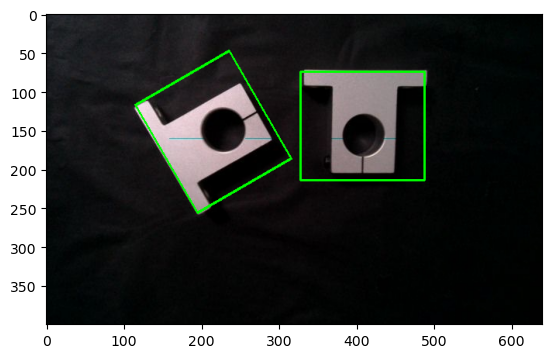

In [15]:
draw_img = target_img.copy()
for roi in nms_rois:
    window = Window.from_array(roi.cpu().numpy())
    draw_img = draw_window(draw_img, window)
plt.imshow(draw_img)

In [ ]:
nms_rois.shape

In [ ]:
possible_rois = rois.rois[scores.squeeze(1) > threshold]

In [ ]:
possible_rois

tensor([[  0.,  64.,   0., 160., 140., 290.],
        [  0.,  72.,   0., 160., 140., 290.],
        [  0.,  72.,   0., 160., 140., 300.],
        ...,
        [  0., 576., 392., 160., 140., 150.],
        [  0., 576., 392., 160., 140., 160.],
        [  0., 576., 392., 160., 140., 170.]])

torch.Size([144000, 1])

In [ ]:
best_score = scores.max()
best_score_index = scores.argmax()

num_steps = rois.get_num_steps()
scores = scores.reshape(num_steps.y, num_steps.x, num_steps.angle)
score_map = scores.max(-1).values.cpu().numpy()

best_window = Window.from_array(rois[best_score_index])
draw_img = draw_window(target_img, best_window)

print(f'best score: {best_score:.4f} at {best_window}')
visualize_result(draw_img, score_map, 0.8, rois, best_window, scores)

In [ ]:
pairwise_iou_rotated(
    torch.tensor([
        [0, 0, 10, 10, 0], 
        [0, 0, 10, 15, 0]
        ]).float(),
    torch.tensor([
        [0, 0, 10, 10, 0],
        [0, 0, 10, 10, 0]
        ]).float())

tensor([[1.0000, 1.0000],
        [0.6667, 0.6667]])

In [ ]:
target_window = Window(210, 160, 160, 140, -120)
target_window = Window(210, 160, 160, 140, 0)

